In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import HTML
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns

In [3]:
# importation des données brutes en utilisant les productid comme index

data_path = "../data/raw/"
df = pd.read_csv(data_path+"X_train_update.csv", index_col="productid").drop("Unnamed: 0", axis=1)
y = pd.read_csv(data_path+"Y_train_CVw08PX.csv")['prdtypecode']
y.index = df.index

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/X_train_update.csv'

In [3]:
# on créer une colonne avec le chemin de l'image correspondante

im_folder_path = data_path+"images/image_train/"
# les noms de fichier image sont de la forme image_imageid_product_productid.jpg
df['image'] = im_folder_path + 'image_' + df['imageid'].astype('str') + '_product_' + df.index.astype('str') +'.jpg'
# plus nécessaire de garder imageid qui est renseigné dans le chemin
df.drop('imageid', axis=1, inplace=True)

In [4]:
# fonction qui permet d'afficher les images du dataframe à partir du chemin des images
# et également les descriptions complètent
# attention de ne pas utiliser max_length trop grand sinon ça va être long à charger

def display_df(df, max_length = 100):
    formatters={
        "image": lambda path: f'<img src="{path}" width="400">',
    }
    display(HTML(df.head(max_length).to_html(escape=False, formatters=formatters)))

In [5]:
# max_load représente le nombre d'octet maxixum chargé en mémoire 10**8 => 100 Mo
# le nombre d'images retourner se fera en fonction de ce paramètre

def images_read(impath, dsize=(150,150), grayscale=True, max_load=10**8):
    n = len(impath)
    total_size = n*dsize[0]*dsize[1] if grayscale else n*dsize[0]*dsize[1]*3
    stop = int(n * (max_load/total_size)) if total_size > max_load else n
    images = []
    if grayscale:
        for i in range(stop):
            im = cv2.imread(impath.iloc[i], cv2.IMREAD_GRAYSCALE)
            images.append(cv2.resize(im, dsize = dsize))
    else:
        for i in range(stop):
            im = cv2.imread(impath.iloc[i], cv2.IMREAD_COLOR)
            # cv2 encodes les images aux formats BGR,
            # on les transforme en RGB pour les afficher correctement avec matplotlib 
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            images.append(cv2.resize(im, dsize = dsize))
    return np.array(images)

In [6]:
# images = images_read(df['image'], max_load=2*10**9) # permet de charger toute les images mais un peut long à tourner
# images = images.reshape((images.shape[0], images.shape[1]*images.shape[2]))

In [7]:
# fonction prise telle quelle du module "Méthodes de réduction de dimension - Manifold learning"

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i], dsize = (28,28)), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

In [8]:
N = 5000
im28x28 = images_read(df['image'].iloc[:N], dsize=(28,28), max_load=2*10**9)
im28x28 = im28x28.reshape((im28x28.shape[0], im28x28.shape[1]*im28x28.shape[2]))
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(im28x28[:N], y[:N])
imt = lda.transform(im28x28[:N])

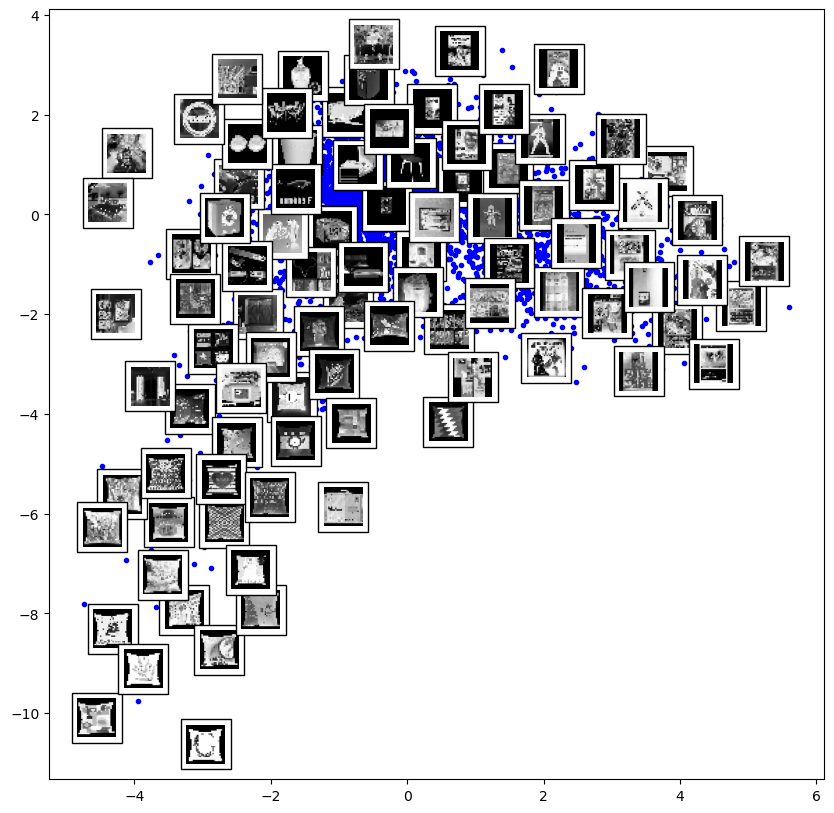

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(imt, lda, im28x28[:N].reshape((-1,28,28)), prefit=True, ax=ax, thumb_frac=0.05)


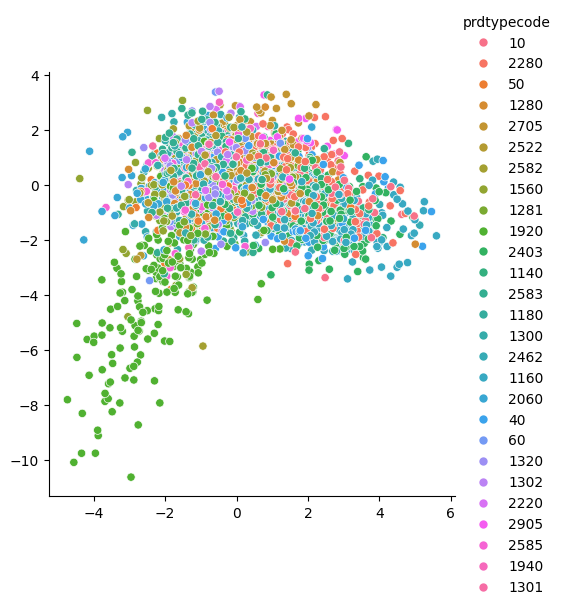

In [10]:
sns.relplot(x=imt[:,0], y=imt[:,1], hue=y[:N].astype('str'))

# seul la catégorie 1920 semble facilement se démarquer (en bas à gauche)  avec la LDA en deux dimensions
# (essentiellement les coussins / oreillets comme on le voit au dessus)
# à doite on voit des objet plus rectangulaire ressemblant à des livres / posters / boite de jeu
# qui sont surement représenter dans plein de catégorie
# pas évident de voir ce que ces axes peuvent représenter

In [50]:
# Ce code correspond à la partie manuelle du processus de définition et de nomination des catégories :
# en sélectionnant une catégorie spécifique (ici cat = 2705) et en affichant les premières entrées associées
# avec display_df(df[y == cat], 10), nous examinons les produits qui la composent.
# L’observation se fait à la fois sur les images, mais également sur le contenu textuel des colonnes "designation" et "description".
# Cette analyse nous permet de proposer un nom pertinent et cohérent pour la catégorie,
# nom qui sera ensuite contrasté et affiné à l’aide des nuages de mots générés afin de valider ou ajuster la dénomination retenue.

# exemple; on affiche les 5 premières entrées de la catégorie 2583

cat = 2705
display_df(df[y == cat], 10)

# à priori les coussins peuvent facilement se démarquer par l'image mais également par la description / designation

,designation,description,image
productid,,,
278535884,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en être le vainqueur incontesté. Mais Sophie s'en mêle et chambarde tous ses plans...,
476383013,Ne Regardez Pas Le Voleur Qui Passe,Depuis quatre ans le mensuel Marie Claire organise un concours auprès de ses lectrices et lecteurs lui permettant d'attribuer le Prix Marie Claire du futur écrivain. Cette année pour la première fois les auteurs de premiers romans étaient les seuls à participer. Sur un thème imposé ' Changer ' 300 manuscrits se sont disputé les faveurs d'un jury composé de journalistes d'éditeurs et d'enseignants de l'écriture. C'est à l'unanimité que le prix 2006 a été décerné à Isabelle Kauffmann pour son roman aussi insolite que captivant. Ne regardez pas le voleur qui passe entraîne le lecteur sur les traces de l'énigmatique Lose personnage inquiétant capable de voler des fragments de vie à ceux dont il croise le regard. Une quête haletante jusqu'au bout de l'étrange.,
2537777042,Les Crimes Secrets De Napoléon Buonaparte - Faits Historiques Recueillis Par Une Victime De Sa Tyrannie,NaN,
2142477536,En Écoutant Tolstoï ; Entretiens Sur La Guerre Et Quelques Autres Sujets,NaN,
1350498866,Les Révélations Du Crime Ou Cambray Et Ses Complices,NaN,
278528834,La Mer Et Les Marins Scènes Maritimes,NaN,
278517003,L'intégrale Des ¿Uvres De Jules Verne - Tome 3,Tome III : Un billet de loterie – Les tribulations d'un chinois en Chine – Le secret de Wilhelm Storitz – M. Ré-Dièze et Mlle Mi-Bémol – Le village aérien – De la Terre à la Lune – Le tour du monde en quatre-vingts jours – Une ville flottante.,
3212831992,Mon Premier Amour : Les Chroniques D'un Grand Rêveur,NaN,
278533940,2001 L'odyssée De L'espace,Ce livre est né du désir d'explorer en quoi consistent les trois énigmes majeures de 2001 l'odyssée de l'espace : le monolithe et la naissance de l'humanité le langage et la technique les modifications des formes de la sensibilité (l'espace et le temps) lors de l'épisode final. L'auteur précise d'emblée qu'il ne traitera pas ces énigmes comme des problèmes à résoudre c'est-à-dire à dissiper. Il considère que le ' message ' du film n'est pas un message crypté qu'il conviendrait de décoder et se propose de déployer la consistance de ces énigmes de dire ce qui s'y passe ce qui s'y joue tout en interrogeant de manière critique le regard que l'on porte généralement sur elles. Il mettra en évidence dans une approche qui articule analyse précise de séquences et réflexion philosophique le caractère central de la question du temps dans 2001 (l'odyssée de l'espace devient une odyssée du temps) ainsi que les dimensions artistiques d'un film défini comme passage sensible d'idées.,


In [104]:
# max_load représente le nombre d'octet maxixum chargé en mémoire 10**8 => 100 Mo
# le nombre d'images retourner se fera en fonction de ce paramètre
def images_read(impath, dsize=(150,150), grayscale=True, max_load=10**8):
    n = len(impath)
    total_size = n*dsize[0]*dsize[1] if grayscale else n*dsize[0]*dsize[1]*3
    stop = int(n * (max_load/total_size)) if total_size > max_load else n
    images = []
    if grayscale:
        for i in range(stop):
            im = cv2.imread(impath.iloc[i], cv2.IMREAD_GRAYSCALE)
            images.append(cv2.resize(im, dsize = dsize))
    else:
        for i in range(stop):
            im = cv2.imread(impath.iloc[i], cv2.IMREAD_COLOR)
            # cv2 encodes les images aux formats BGR,
            # on les transforme en RGB pour les afficher correctement avec matplotlib
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            images.append(cv2.resize(im, dsize = dsize))
    return np.array(images)

images = images_read(df['image'], dsize=(20,20), max_load=2*10**9)
images = pd.DataFrame(images.reshape((images.shape[0],images.shape[1]*images.shape[2])), index=df.index)

In [5]:
# Étape 1 : Concaténation du texte et des images réduites
    ## Ici, on crée un nouveau DataFrame df_full qui combine :
        # 1) Les colonnes 'designation' et 'description' du DataFrame df (texte du produit)
        # 2) Les colonnes de images réduites (miniatures ou vecteurs de caractéristiques) provenant du DataFrame 'images'
# La concaténation se fait horizontalement (axis=1), donc chaque ligne correspond toujours au même produit,
# mais maintenant elle contient à la fois le texte et les informations de l'image
df_full = pd.concat([df[['designation', 'description']], images], axis=1)

#   Étape 2 : Détection des doublons exacts
    # duplicated(keep=False) renvoie une série booléenne :
    # True pour toutes les lignes qui ont des doublons exacts dans df_full
    # La comparaison se fait sur toutes les colonnes (texte + image)

masque_doublons = df_full.duplicated(keep=False)

# Étape 3 : Filtrage des doublons
    # On applique le masque sur le DataFrame original df
    # pour récupérer uniquement les produits ayant le même texte et la même image réduite
df_doublons = df.loc[masque_doublons]
 
#Étape 4 : Affichage du nombre de produits dupliqués
    # On affiche le nombre total de produits qui ont exactement le même texte et la même image réduite
print("Nombre de produits avec le même texte et image réduite :", len(df_doublons))

NameError: name 'df' is not defined

In [93]:
# Affichage du nombre total de lignes dans le DataFrame original
    # len(df) renvoie le nombre total de produits dans le DataFrame df

print("Total lignes:", len(df))

# Affichage de la proportion de doublons
    # len(df_doublons)/len(df) calcule la proportion de produits ayant exactement
    # le même texte et la même image réduite par rapport au nombre total de produits
print("Proportion de doublons:", len(df_doublons)/len(df))

Total lignes: 84916
Proportion de doublons: 0.007572188986763389


In [94]:
# Affichage des premières lignes du DataFrame des doublons

df_doublons.head()

,designation,description,image
productid,,,
3793572222,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,../data/raw/images/image_train/image_124564418...
4128438373,Pompe de filtration Speck Badu 95,NaN,../data/raw/images/image_train/image_129596037...
3929900526,Film solaire de piscine ronde PE 250 cm Bleu,<p>Ce film solaire de piscine pose directement...,../data/raw/images/image_train/image_126521467...
3793573976,Tente Pliante V3s5-Pro Pvc Blanc - 4 X 4 M - L...,Tente pliante V3S5 Pro - 16 m² - PVC 500 gr/m...,../data/raw/images/image_train/image_124564555...
3929899793,Tuyau de piscine avec colliers de serrage Bleu...,<p>Ce tuyau de piscine est un choix idéal pour...,../data/raw/images/image_train/image_126522426...


In [92]:
df_full

,designation,description,0,1,2,3,4,5,6,7,...,390,391,392,393,394,395,396,397,398,399
productid,,,,,,,,,,,,,,,,,,,,,
3804725264,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
436067568,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
201115110,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
50418756,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
278535884,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206719094,The Sims [ Import Anglais ],NaN,255,255,255,9,3,4,8,10,...,69,37,69,34,27,17,14,255,255,255
3065095706,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
440707564,Journal Officiel De La Republique Francaise N°...,NaN,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


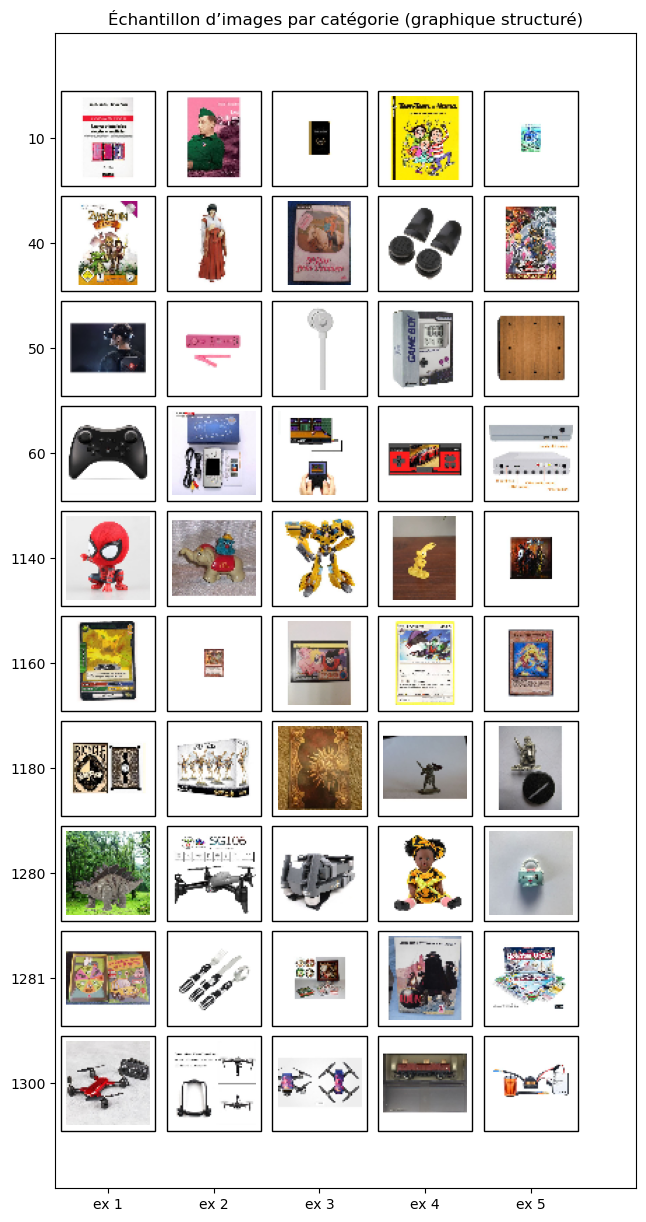

In [103]:
# Import des bibliothèques nécessaires

import matplotlib.pyplot as plt   # pour créer les graphiques
import matplotlib.offsetbox as offsetbox  # pour afficher des images dans le graphique
import cv2    # pour lire et manipuler les images
import numpy as np # pour la manipulation de tableaux et calculs
# Paramètres principaux
n_images = 5 # nombre d’images à afficher par catégorie
categories = sorted(y.unique())[:10]   # on limite à 10 catégories pour plus de lisibilité
img_size = (60, 60) # taille des images pour l’affichage (largeur x hauteur)

# Création de la figure
    # On crée une figure avec un axe, dont la taille dépend du nombre d’images et de catégories

fig, ax = plt.subplots(figsize=(n_images*1.5, len(categories)*1.5))

# Affichage des images par catégorie 
for i, cat in enumerate(categories):
    # Sélection d’un échantillon aléatoire de produits pour la catégorie courante
    subset = df[y == cat].sample(min(n_images, len(df[y == cat])), random_state=42)
    for j, path in enumerate(subset['image']): 
         # Lecture de l’image depuis le chemin
        img = cv2.imread(path)
        if img is not None:
             # Conversion de l’image de BGR (OpenCV) à RGB (matplotlib)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
             # Redimensionnement de l’image pour qu’elle soit uniforme
            img = cv2.resize(img, img_size)
               # Création d’une "boîte d’image" pour l’afficher à la position (j, -i)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, zoom=1), (j, -i))
             # Ajout de l’image sur l’axe
            ax.add_artist(imagebox)

# Configuration des axes
    # Positions et étiquettes pour l’axe Y (les catégories)
ax.set_yticks(-np.arange(len(categories)))
ax.set_yticklabels(categories)
# Positions et étiquettes pour l’axe X (les exemples)
ax.set_xticks(range(n_images))
ax.set_xticklabels([f"ex {i+1}" for i in range(n_images)])
# Limites des axes pour que toutes les images soient visibles
ax.set_xlim(-0.5, n_images)
ax.set_ylim(-len(categories), 1)
# Titre du graphique
ax.set_title("Échantillon d’images par catégorie (graphique structuré)")
plt.show()
